## COM4402 - Introducción a la Inteligencia Artificial
###*2do semestre del 2023*
# **Ayudantía 4:** Redes neuronales con PyTorch

*Ayudante: Camila Rapu H*

*Ayudante Corrector: Felipe Gómez*

*Profesores: Ignacio Bugueño, Alfonso Ehijo*

> En este notebook veremos como podemos usar nuestras propias redes neuronales con PyTorch.

---
## Antes de ejecutar el código, activar el uso de GPU en Google Colab.

* Ir a "Entorno de Ejecución" en el menú superior
* Haga click en "Cambiar tipo de entorno de ejecución"
* Seleccionar "T4 GPU" en "Acelerador de Hardware"
---

---
# Clasificación de dígitos
---

El problema que veremos será la clasificación de dígitos, con el dataset *Optical Recognition of Handwritten Digits Data Set* que contiene imágenes de 8x8 pixeles con dígitos manuscritos. El objetivo es lograr reconocer a que dígito corresponde cada muestra o imágen.

# Subir archivos

Cargaremos el dataset de forma remota con `wget` desde un repositorio de GitHub. Así podremos acceder al dataset solo con ejecutar las siguientes lineas, ya que este descarga los archivos directamente en el ambiente de Colab.

In [2]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt

--2023-10-29 00:16:57--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt’

1_digits_train.txt  100%[===================>] 625.59K  --.-KB/s    in 0.02s   

2023-10-29 00:16:57 (34.1 MB/s) - ‘1_digits_train.txt’ saved [640604/640604]

--2023-10-29 00:16:57--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200

# Cargar dataset

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim

In [4]:
# Cargar conjuntos de datos de entrenamiento y prueba
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_test = pd.read_csv('1_digits_test.txt', names = column_names)

> **Nota:** Con *head()* podemos ver las primeras 5 muestras o filas de un DataFrame.

In [5]:
df_train_val.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


In [6]:
df_test.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7


Vemos que tenemos 64 características más la columna de clases. Estas características corresponden a los pixeles que conforman las imágenes de 8x8, por ello el dataset tiene 64 dimensiones.

## Dividimos los datos de entrenamiento en validación y entrenamiento.

In [7]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)
print("Muestras de entrenamiento: ", len(df_train))
print("Muestras de validación: ", len(df_val))
print("Muestras de prueba: ", len(df_test))
print("Muestras totales: ", len(df_train_val)+len(df_test))

Muestras de entrenamiento:  3042
Muestras de validación:  1305
Muestras de prueba:  1272
Muestras totales:  5619


## Normalización de los datos

In [8]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])
df_train

<ipython-input-8-9e57453e69e1>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-8-9e57453e69e1>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-8-9e57453e69e1>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


# Dataloaders para utilizar los datos en PyTorch

In [9]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [10]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

# Entrenamiento de la red
En el siguiente código entrenamos el modelo anterior por 250 epocas, procesando cada batch o lote en el que los dataloaders particionaron los datos. A lo largo del entrenamiento, calculamos la perdida (loss) de la red para poder visualizar su rendimiento luego.

#Escenarios

##Esc A

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
import time

# -- Modelo con una capa oculta de 10 neuronas y activación ReLU --
model = nn.Sequential(
    nn.Linear(64, 10),  # Capa de entrada
    nn.ReLU(),          # Función de activación ReLU
    nn.Linear(10, 10)   # Capa de salida
)

# Se le indica a PyTorch que correremos el modelo en GPU si está disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Definimos la función de pérdida y el optimizador que utilizaremos
criterion = nn.CrossEntropyLoss()                      # Función de pérdida
optimizer = optim.Adam(model.parameters(), lr=1e-3)    # Optimizador

start = time.time()

# Guardar resultados del loss y las épocas que duró el entrenamiento
loss_train = []
loss_val = []
accuracy_val = []  # Lista para guardar el accuracy de validación
epochs = []

# Entrenamiento de la red por un máximo de 1000 épocas
max_epochs = 1000

# Variables para el early stopping
best_val_loss = float('inf')
patience = 10  # Número máximo de épocas sin mejora permitidas
counter = 0

for epoch in range(max_epochs):
    # Guardar loss y accuracy de cada batch
    loss_train_batches = []
    loss_val_batches = []
    accuracy_val_batches = []  # Lista para guardar el accuracy de validación por lotes

    # Entrenamiento --------------------------------------------------------------
    model.train()
    # Debemos recorrer cada batch (lote de los datos)
    for i, data in enumerate(dataloader_train, 0):
        # Procesar el batch actual
        inputs = data["features"].to(device)  # Características
        labels = data["labels"].to(device)    # Clases
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_train_batches.append(loss.item())

    # Guardamos el loss de entrenamiento de la época actual
    loss_train.append(np.mean(loss_train_batches))

    # Validación --------------------------------------------------------------
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_val_batches.append(loss.item())

            # Calcula las predicciones del modelo
            _, predicted = torch.max(outputs, 1)

            # Convierte las etiquetas y predicciones al formato de CPU para calcular el accuracy
            labels_cpu = labels.cpu().numpy()
            predicted_cpu = predicted.cpu().numpy()

            accuracy = accuracy_score(labels_cpu, predicted_cpu)
            accuracy_val_batches.append(accuracy)

    # Guardamos el Loss de validación y el accuracy de validación de la época actual
    loss_val.append(np.mean(loss_val_batches))
    accuracy_val.append(np.mean(accuracy_val_batches))

    # Guardamos la época
    epochs.append(epoch)

    # Imprimir la pérdida de entrenamiento/validación y el accuracy de validación en la época actual
    print(f"Epoch: {epoch}, train loss: {loss_train[epoch]:.4f}, val loss: {loss_val[epoch]:.4f}, val accuracy: {accuracy_val[epoch]:.4f}")

    # Early Stopping: Verificar si la pérdida de validación ha dejado de mejorar
    if loss_val[epoch] < best_val_loss:
        best_val_loss = loss_val[epoch]
        counter = 0  # Reiniciar el contador
    else:
        counter += 1

    if counter >= patience:
        print("Deteniendo el entrenamiento debido a falta de mejora en la validación.")
        break  # Salir del bucle de entrenamiento

end = time.time()
print(f'Finished Training, total time {end - start:.2f} seconds')


Epoch: 0, train loss: 2.2670, val loss: 2.1541, val accuracy: 0.2170
Epoch: 1, train loss: 2.0854, val loss: 1.9827, val accuracy: 0.3491
Epoch: 2, train loss: 1.9054, val loss: 1.7919, val accuracy: 0.4824
Epoch: 3, train loss: 1.7167, val loss: 1.6074, val accuracy: 0.5956
Epoch: 4, train loss: 1.5248, val loss: 1.4032, val accuracy: 0.6990
Epoch: 5, train loss: 1.3343, val loss: 1.2092, val accuracy: 0.7517
Epoch: 6, train loss: 1.1558, val loss: 1.0366, val accuracy: 0.7965
Epoch: 7, train loss: 0.9981, val loss: 0.8922, val accuracy: 0.8156
Epoch: 8, train loss: 0.8641, val loss: 0.7957, val accuracy: 0.8305
Epoch: 9, train loss: 0.7513, val loss: 0.6662, val accuracy: 0.8613
Epoch: 10, train loss: 0.6597, val loss: 0.5862, val accuracy: 0.8705
Epoch: 11, train loss: 0.5849, val loss: 0.5464, val accuracy: 0.8732
Epoch: 12, train loss: 0.5265, val loss: 0.4710, val accuracy: 0.8913
Epoch: 13, train loss: 0.4763, val loss: 0.4486, val accuracy: 0.8946
Epoch: 14, train loss: 0.4371,

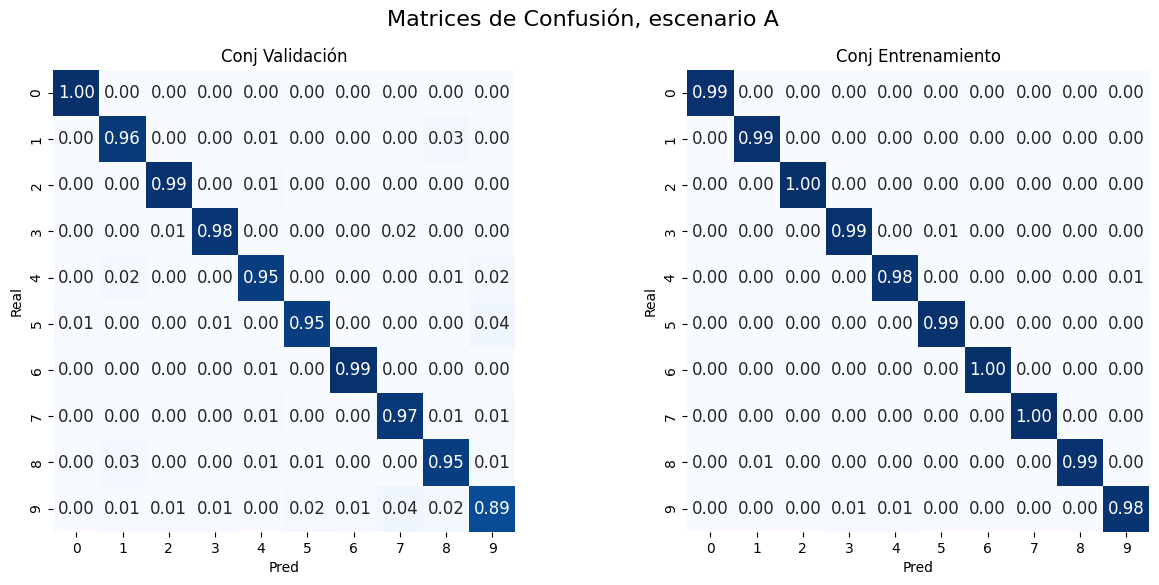

Precisión de entrenamiento: 99.11%
Precisión de validación: 96.17%


In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener predicciones y etiquetas para un conjunto dado
def get_predictions_and_labels(model, dataloader, device):
    preds = []
    labels = []

    model.eval()  # Cambiar el modo del modelo a evaluación
    with torch.no_grad():
        for batch in dataloader:
            features, batch_labels = batch["features"].to(device), batch["labels"].to(device)
            outputs = model(features)  # Realizar predicciones
            _, batch_preds = torch.max(outputs, 1)
            preds.extend(batch_preds.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return preds, labels

# Obtener predicciones y etiquetas para el conjunto de validación
val_preds, val_labels = get_predictions_and_labels(model, dataloader_val, device)

# Obtener predicciones y etiquetas para el conjunto de entrenamiento
train_preds, train_labels = get_predictions_and_labels(model, dataloader_train, device)

# Calcular las matrices de confusión
val_confusion = confusion_matrix(val_labels, val_preds, normalize='true')
train_confusion = confusion_matrix(train_labels, train_preds, normalize='true')

# Crear una figura y ejes para la matriz de confusión
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Matrices de Confusión, escenario A", fontsize=16)

# Visualizar la matriz de confusión de validación
ax = axes[0]
sns.heatmap(val_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=False, square=True, ax=ax, annot_kws={"size": 12})
ax.set_title("Conj Validación")
ax.set_xlabel('Pred')
ax.set_ylabel('Real')

# Visualizar la matriz de confusión de entrenamiento
ax = axes[1]
sns.heatmap(train_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=False, square=True, ax=ax, annot_kws={"size": 12})
ax.set_title("Conj Entrenamiento")
ax.set_xlabel('Pred')
ax.set_ylabel('Real')

# Mostrar la figura
plt.show()

# Calcular y mostrar las precisiones de entrenamiento y validación
train_accuracy = accuracy_score(train_labels, train_preds)
val_accuracy = accuracy_score(val_labels, val_preds)

print(f'Precisión de entrenamiento: {train_accuracy * 100:.2f}%')
print(f'Precisión de validación: {val_accuracy * 100:.2f}%')


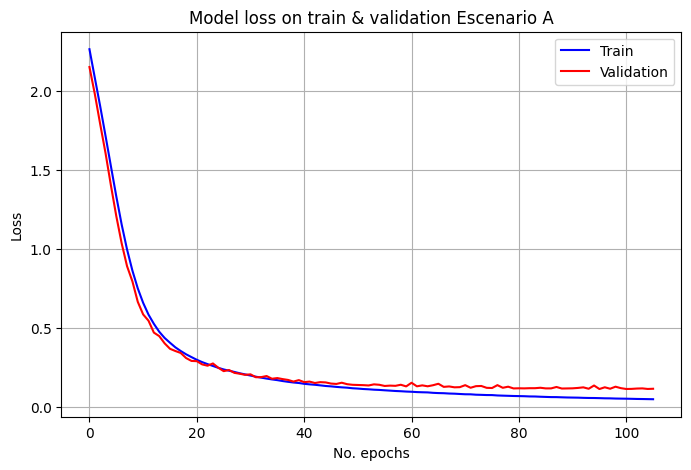

In [12]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation Escenario A')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

## Esc B

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
import time

# -- Modelo con una capa oculta de 40 neuronas y activación ReLU --
model = nn.Sequential(
    nn.Linear(64, 40),  # Capa de entrada
    nn.ReLU(),          # Función de activación ReLU
    nn.Linear(40, 10)   # Capa de salida
)

# Se le indica a PyTorch que correremos el modelo en GPU si está disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Definimos la función de pérdida y el optimizador que utilizaremos
criterion = nn.CrossEntropyLoss()                      # Función de pérdida
optimizer = optim.Adam(model.parameters(), lr=1e-3)    # Optimizador

start = time.time()

# Guardar resultados del loss y las épocas que duró el entrenamiento
loss_train = []
loss_val = []
accuracy_val = []  # Lista para guardar el accuracy de validación
epochs = []

# Entrenamiento de la red por un máximo de 1000 épocas
max_epochs = 1000

# Variables para el early stopping
best_val_loss = float('inf')
patience = 10  # Número máximo de épocas sin mejora permitidas
counter = 0

for epoch in range(max_epochs):
    # Guardar loss y accuracy de cada batch
    loss_train_batches = []
    loss_val_batches = []
    accuracy_val_batches = []  # Lista para guardar el accuracy de validación por lotes

    # Entrenamiento --------------------------------------------------------------
    model.train()
    # Debemos recorrer cada batch (lote de los datos)
    for i, data in enumerate(dataloader_train, 0):
        # Procesar el batch actual
        inputs = data["features"].to(device)  # Características
        labels = data["labels"].to(device)    # Clases
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_train_batches.append(loss.item())

    # Guardamos el loss de entrenamiento de la época actual
    loss_train.append(np.mean(loss_train_batches))

    # Validación --------------------------------------------------------------
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_val_batches.append(loss.item())

            # Calcula las predicciones del modelo
            _, predicted = torch.max(outputs, 1)

            # Convierte las etiquetas y predicciones al formato de CPU para calcular el accuracy
            labels_cpu = labels.cpu().numpy()
            predicted_cpu = predicted.cpu().numpy()

            accuracy = accuracy_score(labels_cpu, predicted_cpu)
            accuracy_val_batches.append(accuracy)

    # Guardamos el Loss de validación y el accuracy de validación de la época actual
    loss_val.append(np.mean(loss_val_batches))
    accuracy_val.append(np.mean(accuracy_val_batches))

    # Guardamos la época
    epochs.append(epoch)

    # Imprimir la pérdida de entrenamiento/validación y el accuracy de validación en la época actual
    print(f"Epoch: {epoch}, train loss: {loss_train[epoch]:.4f}, val loss: {loss_val[epoch]:.4f}, val accuracy: {accuracy_val[epoch]:.4f}")

    # Early Stopping: Verificar si la pérdida de validación ha dejado de mejorar
    if loss_val[epoch] < best_val_loss:
        best_val_loss = loss_val[epoch]
        counter = 0  # Reiniciar el contador
    else:
        counter += 1

    if counter >= patience:
        print("Deteniendo el entrenamiento debido a falta de mejora en la validación.")
        break  # Salir del bucle de entrenamiento

end = time.time()
print(f'Finished Training, total time {end - start:.2f} seconds')


Epoch: 0, train loss: 2.1057, val loss: 1.9016, val accuracy: 0.5057
Epoch: 1, train loss: 1.6821, val loss: 1.4559, val accuracy: 0.7923
Epoch: 2, train loss: 1.2472, val loss: 1.0294, val accuracy: 0.8447
Epoch: 3, train loss: 0.8700, val loss: 0.7054, val accuracy: 0.8889
Epoch: 4, train loss: 0.6058, val loss: 0.5040, val accuracy: 0.9290
Epoch: 5, train loss: 0.4439, val loss: 0.3888, val accuracy: 0.9309
Epoch: 6, train loss: 0.3464, val loss: 0.3054, val accuracy: 0.9467
Epoch: 7, train loss: 0.2847, val loss: 0.2572, val accuracy: 0.9496
Epoch: 8, train loss: 0.2416, val loss: 0.2285, val accuracy: 0.9509
Epoch: 9, train loss: 0.2115, val loss: 0.2165, val accuracy: 0.9486
Epoch: 10, train loss: 0.1881, val loss: 0.1930, val accuracy: 0.9537
Epoch: 11, train loss: 0.1694, val loss: 0.1742, val accuracy: 0.9587
Epoch: 12, train loss: 0.1540, val loss: 0.1622, val accuracy: 0.9616
Epoch: 13, train loss: 0.1422, val loss: 0.1498, val accuracy: 0.9623
Epoch: 14, train loss: 0.1311,

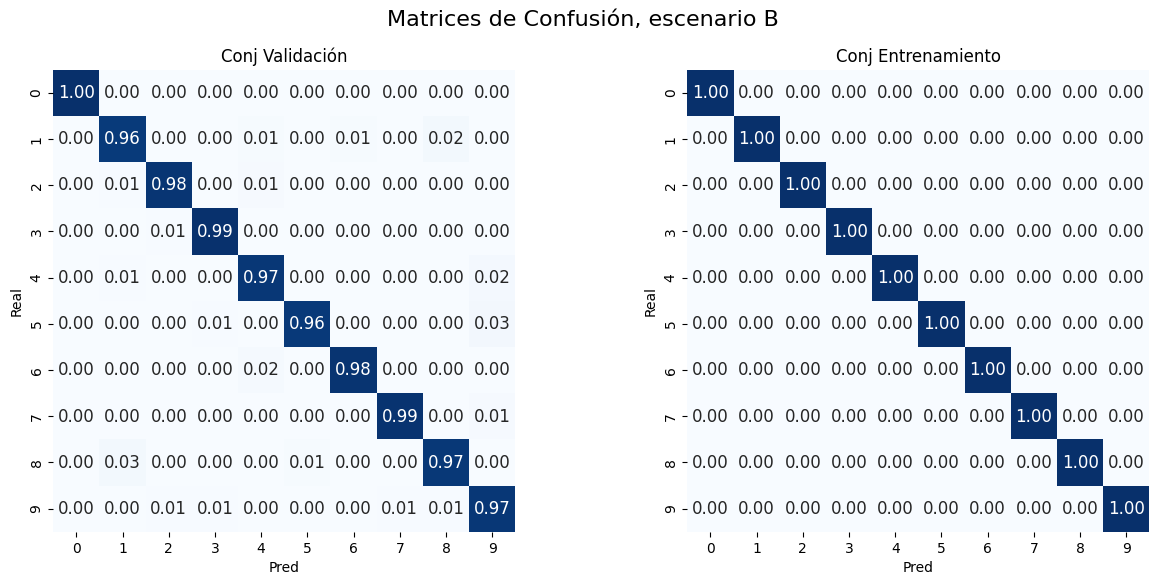

Precisión de entrenamiento: 100.00%
Precisión de validación: 97.70%


In [14]:
#matrices

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener predicciones y etiquetas para el conjunto de validación
val_preds = []
val_labels = []

model.eval()  # Cambiar el modo del modelo a evaluación
with torch.no_grad():
    for batch in dataloader_val:
        features, labels = batch["features"].to(device), batch["labels"].to(device)
        outputs = model(features)  # Realizar predicciones
        _, preds = torch.max(outputs, 1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Obtener predicciones y etiquetas para el conjunto de entrenamiento
train_preds = []
train_labels = []

model.eval()  # Cambiar el modo del modelo a evaluación
with torch.no_grad():
    for batch in dataloader_train:
        features, labels = batch["features"].to(device), batch["labels"].to(device)
        outputs = model(features)  # Realizar predicciones
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

# Calcular las matrices de confusión
val_confusion = confusion_matrix(val_labels, val_preds, normalize='true')
train_confusion = confusion_matrix(train_labels, train_preds, normalize='true')

# Crear una figura y ejes para la matriz de confusión
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Matrices de Confusión, escenario B", fontsize=16)

# Visualizar la matriz de confusión de validación
ax = axes[0]
sns.heatmap(val_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=False, square=True, ax=ax, annot_kws={"size": 12})
ax.set_title("Conj Validación")
ax.set_xlabel('Pred')
ax.set_ylabel('Real')

# Visualizar la matriz de confusión de entrenamiento
ax = axes[1]
sns.heatmap(train_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=False, square=True, ax=ax, annot_kws={"size": 12})
ax.set_title("Conj Entrenamiento")
ax.set_xlabel('Pred')
ax.set_ylabel('Real')

# Mostrar la figura
plt.show()

# Calcular y mostrar las precisiones de entrenamiento y validación
train_accuracy = accuracy_score(train_labels, train_preds)
val_accuracy = accuracy_score(val_labels, val_preds)

print(f'Precisión de entrenamiento: {train_accuracy * 100:.2f}%')
print(f'Precisión de validación: {val_accuracy * 100:.2f}%')



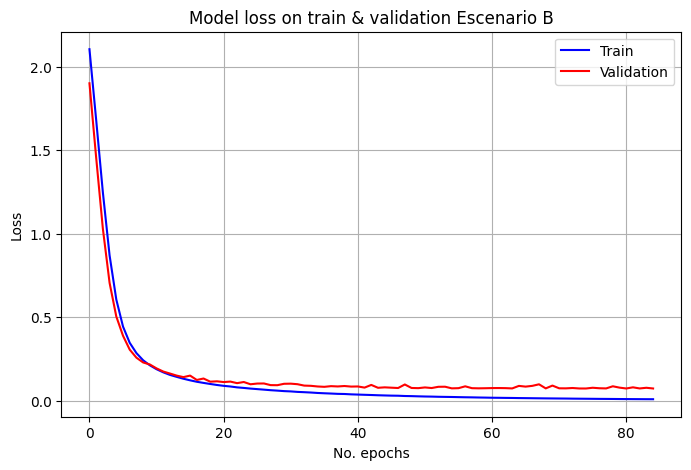

In [15]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation Escenario B')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

#ESC c

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
import time

# -- Modelo con una capa oculta de 10 neuronas y activación ReLU --
model = nn.Sequential(
    nn.Linear(64, 10),  # Capa de entrada
    nn.Tanh(),          # Función de activación ReLU
    nn.Linear(10, 10)   # Capa de salida
)

# Se le indica a PyTorch que correremos el modelo en GPU si está disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Definimos la función de pérdida y el optimizador que utilizaremos
criterion = nn.CrossEntropyLoss()                      # Función de pérdida
optimizer = optim.Adam(model.parameters(), lr=1e-3)    # Optimizador

start = time.time()

# Guardar resultados del loss y las épocas que duró el entrenamiento
loss_train = []
loss_val = []
accuracy_val = []  # Lista para guardar el accuracy de validación
epochs = []

# Entrenamiento de la red por un máximo de 1000 épocas
max_epochs = 1000

# Variables para el early stopping
best_val_loss = float('inf')
patience = 10  # Número máximo de épocas sin mejora permitidas
counter = 0

for epoch in range(max_epochs):
    # Guardar loss y accuracy de cada batch
    loss_train_batches = []
    loss_val_batches = []
    accuracy_val_batches = []  # Lista para guardar el accuracy de validación por lotes

    # Entrenamiento --------------------------------------------------------------
    model.train()
    # Debemos recorrer cada batch (lote de los datos)
    for i, data in enumerate(dataloader_train, 0):
        # Procesar el batch actual
        inputs = data["features"].to(device)  # Características
        labels = data["labels"].to(device)    # Clases
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_train_batches.append(loss.item())

    # Guardamos el loss de entrenamiento de la época actual
    loss_train.append(np.mean(loss_train_batches))

    # Validación --------------------------------------------------------------
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_val_batches.append(loss.item())

            # Calcula las predicciones del modelo
            _, predicted = torch.max(outputs, 1)

            # Convierte las etiquetas y predicciones al formato de CPU para calcular el accuracy
            labels_cpu = labels.cpu().numpy()
            predicted_cpu = predicted.cpu().numpy()

            accuracy = accuracy_score(labels_cpu, predicted_cpu)
            accuracy_val_batches.append(accuracy)

    # Guardamos el Loss de validación y el accuracy de validación de la época actual
    loss_val.append(np.mean(loss_val_batches))
    accuracy_val.append(np.mean(accuracy_val_batches))

    # Guardamos la época
    epochs.append(epoch)

    # Imprimir la pérdida de entrenamiento/validación y el accuracy de validación en la época actual
    print(f"Epoch: {epoch}, train loss: {loss_train[epoch]:.4f}, val loss: {loss_val[epoch]:.4f}, val accuracy: {accuracy_val[epoch]:.4f}")

    # Early Stopping: Verificar si la pérdida de validación ha dejado de mejorar
    if loss_val[epoch] < best_val_loss:
        best_val_loss = loss_val[epoch]
        counter = 0  # Reiniciar el contador
    else:
        counter += 1

    if counter >= patience:
        print("Deteniendo el entrenamiento debido a falta de mejora en la validación.")
        break  # Salir del bucle de entrenamiento

end = time.time()
print(f'Finished Training, total time {end - start:.2f} seconds')





Epoch: 0, train loss: 2.1691, val loss: 2.0352, val accuracy: 0.3752
Epoch: 1, train loss: 1.9356, val loss: 1.8105, val accuracy: 0.5988
Epoch: 2, train loss: 1.7391, val loss: 1.6361, val accuracy: 0.7149
Epoch: 3, train loss: 1.5678, val loss: 1.4767, val accuracy: 0.7558
Epoch: 4, train loss: 1.4155, val loss: 1.3314, val accuracy: 0.8038
Epoch: 5, train loss: 1.2787, val loss: 1.2088, val accuracy: 0.8306
Epoch: 6, train loss: 1.1565, val loss: 1.0919, val accuracy: 0.8541
Epoch: 7, train loss: 1.0489, val loss: 0.9870, val accuracy: 0.8820
Epoch: 8, train loss: 0.9530, val loss: 0.9138, val accuracy: 0.8825
Epoch: 9, train loss: 0.8691, val loss: 0.8212, val accuracy: 0.9004
Epoch: 10, train loss: 0.7959, val loss: 0.7670, val accuracy: 0.9016
Epoch: 11, train loss: 0.7314, val loss: 0.7017, val accuracy: 0.9190
Epoch: 12, train loss: 0.6759, val loss: 0.6563, val accuracy: 0.9210
Epoch: 13, train loss: 0.6254, val loss: 0.6202, val accuracy: 0.9188
Epoch: 14, train loss: 0.5812,

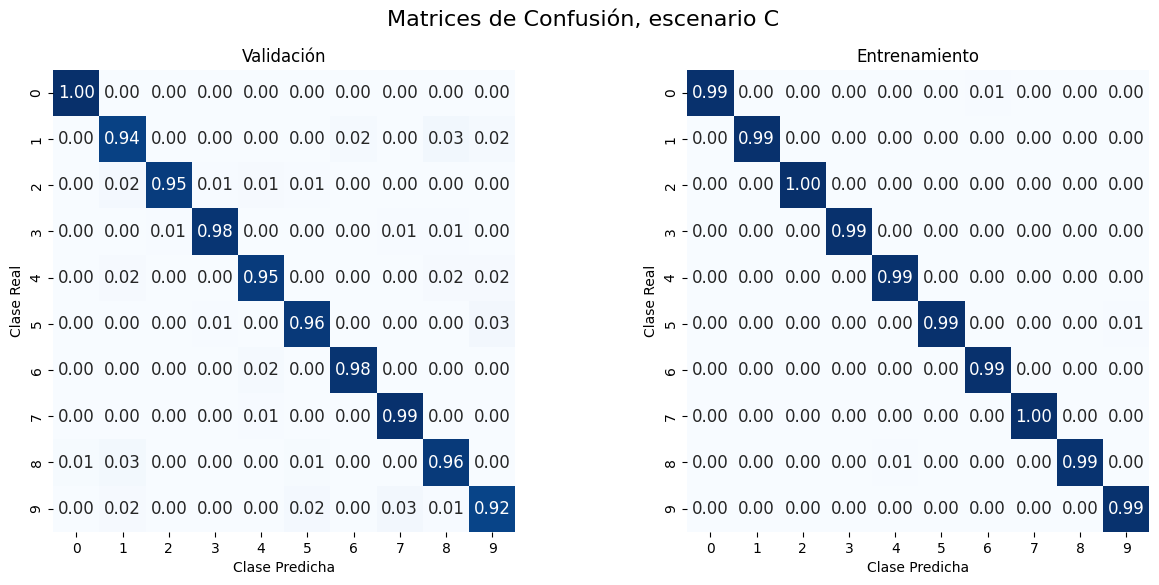

Precisión de entrenamiento: 99.31%
Precisión de validación: 96.40%


In [17]:
#matrices

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener predicciones y etiquetas para el conjunto de validación
val_preds = []
val_labels = []

model.eval()  # Cambiar el modo del modelo a evaluación
with torch.no_grad():
    for batch in dataloader_val:
        features, labels = batch["features"].to(device), batch["labels"].to(device)
        outputs = model(features)  # Realizar predicciones
        _, preds = torch.max(outputs, 1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Obtener predicciones y etiquetas para el conjunto de entrenamiento
train_preds = []
train_labels = []

model.eval()  # Cambiar el modo del modelo a evaluación
with torch.no_grad():
    for batch in dataloader_train:
        features, labels = batch["features"].to(device), batch["labels"].to(device)
        outputs = model(features)  # Realizar predicciones
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

# Calcular las matrices de confusión
val_confusion = confusion_matrix(val_labels, val_preds, normalize='true')
train_confusion = confusion_matrix(train_labels, train_preds, normalize='true')

# Crear una figura y ejes para la matriz de confusión
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Matrices de Confusión, escenario C", fontsize=16)

# Visualizar la matriz de confusión de validación
ax = axes[0]
sns.heatmap(val_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=False, square=True, ax=ax, annot_kws={"size": 12})
ax.set_title("Validación")
ax.set_xlabel('Clase Predicha')
ax.set_ylabel('Clase Real')

# Visualizar la matriz de confusión de entrenamiento
ax = axes[1]
sns.heatmap(train_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=False, square=True, ax=ax, annot_kws={"size": 12})
ax.set_title("Entrenamiento")
ax.set_xlabel('Clase Predicha')
ax.set_ylabel('Clase Real')

# Mostrar la figura
plt.show()

# Calcular y mostrar las precisiones de entrenamiento y validación
train_accuracy = accuracy_score(train_labels, train_preds)
val_accuracy = accuracy_score(val_labels, val_preds)

print(f'Precisión de entrenamiento: {train_accuracy * 100:.2f}%')
print(f'Precisión de validación: {val_accuracy * 100:.2f}%')



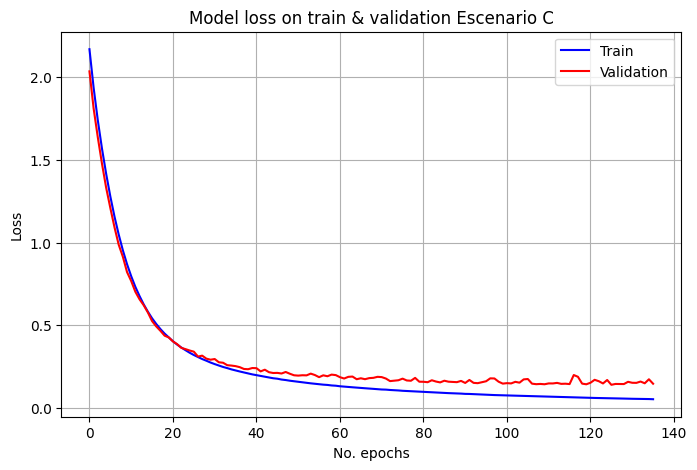

In [18]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation Escenario C')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'b', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

## Esc d

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
import time

# -- Modelo con una capa oculta de 10 neuronas y activación ReLU --
model = nn.Sequential(
    nn.Linear(64, 40),  # Capa de entrada
    nn.Tanh(),          # Función de activación ReLU
    nn.Linear(40, 10)   # Capa de salida
)

# Se le indica a PyTorch que correremos el modelo en GPU si está disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Definimos la función de pérdida y el optimizador que utilizaremos
criterion = nn.CrossEntropyLoss()                      # Función de pérdida
optimizer = optim.Adam(model.parameters(), lr=1e-3)    # Optimizador

start = time.time()

# Guardar resultados del loss y las épocas que duró el entrenamiento
loss_train = []
loss_val = []
accuracy_val = []  # Lista para guardar el accuracy de validación
epochs = []

# Entrenamiento de la red por un máximo de 1000 épocas
max_epochs = 1000

# Variables para el early stopping
best_val_loss = float('inf')
patience = 10  # Número máximo de épocas sin mejora permitidas
counter = 0

for epoch in range(max_epochs):
    # Guardar loss y accuracy de cada batch
    loss_train_batches = []
    loss_val_batches = []
    accuracy_val_batches = []  # Lista para guardar el accuracy de validación por lotes

    # Entrenamiento --------------------------------------------------------------
    model.train()
    # Debemos recorrer cada batch (lote de los datos)
    for i, data in enumerate(dataloader_train, 0):
        # Procesar el batch actual
        inputs = data["features"].to(device)  # Características
        labels = data["labels"].to(device)    # Clases
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_train_batches.append(loss.item())

    # Guardamos el loss de entrenamiento de la época actual
    loss_train.append(np.mean(loss_train_batches))

    # Validación --------------------------------------------------------------
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_val_batches.append(loss.item())

            # Calcula las predicciones del modelo
            _, predicted = torch.max(outputs, 1)

            # Convierte las etiquetas y predicciones al formato de CPU para calcular el accuracy
            labels_cpu = labels.cpu().numpy()
            predicted_cpu = predicted.cpu().numpy()

            accuracy = accuracy_score(labels_cpu, predicted_cpu)
            accuracy_val_batches.append(accuracy)

    # Guardamos el Loss de validación y el accuracy de validación de la época actual
    loss_val.append(np.mean(loss_val_batches))
    accuracy_val.append(np.mean(accuracy_val_batches))

    # Guardamos la época
    epochs.append(epoch)

    # Imprimir la pérdida de entrenamiento/validación y el accuracy de validación en la época actual
    print(f"Epoch: {epoch}, train loss: {loss_train[epoch]:.4f}, val loss: {loss_val[epoch]:.4f}, val accuracy: {accuracy_val[epoch]:.4f}")

    # Early Stopping: Verificar si la pérdida de validación ha dejado de mejorar
    if loss_val[epoch] < best_val_loss:
        best_val_loss = loss_val[epoch]
        counter = 0  # Reiniciar el contador
    else:
        counter += 1

    if counter >= patience:
        print("Deteniendo el entrenamiento debido a falta de mejora en la validación.")
        break  # Salir del bucle de entrenamiento

end = time.time()
print(f'Finished Training, total time {end - start:.2f} seconds')


Epoch: 0, train loss: 1.9874, val loss: 1.6916, val accuracy: 0.7581
Epoch: 1, train loss: 1.4686, val loss: 1.2487, val accuracy: 0.8347
Epoch: 2, train loss: 1.0871, val loss: 0.9408, val accuracy: 0.8818
Epoch: 3, train loss: 0.8186, val loss: 0.7232, val accuracy: 0.8959
Epoch: 4, train loss: 0.6296, val loss: 0.5586, val accuracy: 0.9282
Epoch: 5, train loss: 0.5007, val loss: 0.4482, val accuracy: 0.9403
Epoch: 6, train loss: 0.4106, val loss: 0.3748, val accuracy: 0.9460
Epoch: 7, train loss: 0.3461, val loss: 0.3195, val accuracy: 0.9489
Epoch: 8, train loss: 0.3001, val loss: 0.2804, val accuracy: 0.9488
Epoch: 9, train loss: 0.2647, val loss: 0.2544, val accuracy: 0.9553
Epoch: 10, train loss: 0.2373, val loss: 0.2463, val accuracy: 0.9500
Epoch: 11, train loss: 0.2150, val loss: 0.2282, val accuracy: 0.9514
Epoch: 12, train loss: 0.1968, val loss: 0.1998, val accuracy: 0.9609
Epoch: 13, train loss: 0.1824, val loss: 0.1857, val accuracy: 0.9609
Epoch: 14, train loss: 0.1690,

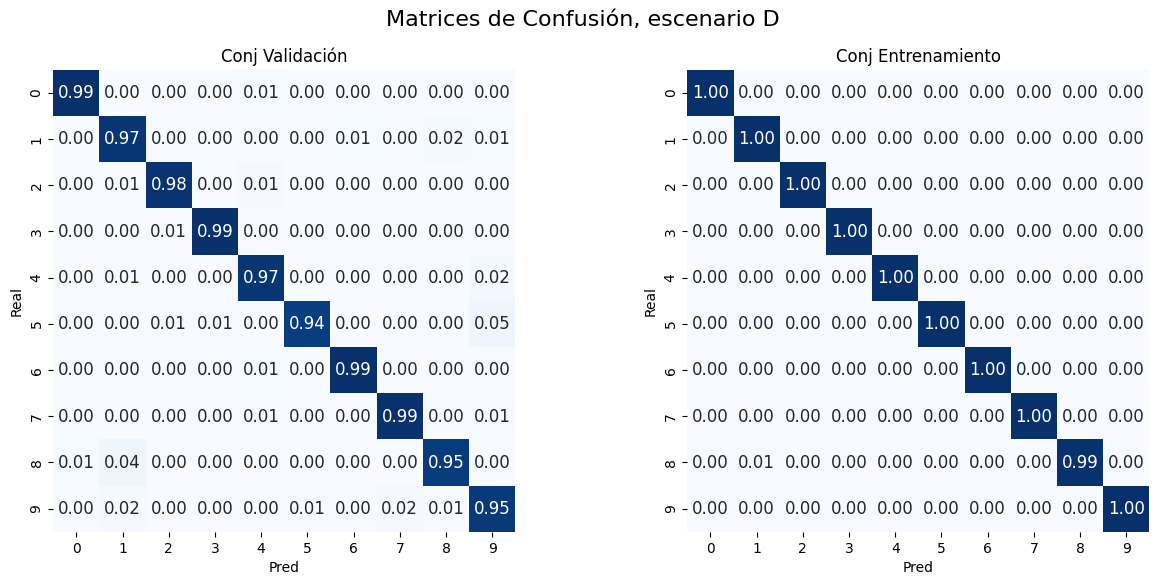

Precisión de entrenamiento: 99.80%
Precisión de validación: 97.24%


In [20]:
#matrices

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener predicciones y etiquetas para el conjunto de validación
val_preds = []
val_labels = []

model.eval()  # Cambiar el modo del modelo a evaluación
with torch.no_grad():
    for batch in dataloader_val:
        features, labels = batch["features"].to(device), batch["labels"].to(device)
        outputs = model(features)  # Realizar predicciones
        _, preds = torch.max(outputs, 1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Obtener predicciones y etiquetas para el conjunto de entrenamiento
train_preds = []
train_labels = []

model.eval()  # Cambiar el modo del modelo a evaluación
with torch.no_grad():
    for batch in dataloader_train:
        features, labels = batch["features"].to(device), batch["labels"].to(device)
        outputs = model(features)  # Realizar predicciones
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

# Calcular las matrices de confusión
val_confusion = confusion_matrix(val_labels, val_preds, normalize='true')
train_confusion = confusion_matrix(train_labels, train_preds, normalize='true')

# Crear una figura y ejes para la matriz de confusión
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Matrices de Confusión, escenario D", fontsize=16)

# Visualizar la matriz de confusión de validación
ax = axes[0]
sns.heatmap(val_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=False, square=True, ax=ax, annot_kws={"size": 12})
ax.set_title("Conj Validación")
ax.set_xlabel('Pred')
ax.set_ylabel('Real')

# Visualizar la matriz de confusión de entrenamiento
ax = axes[1]
sns.heatmap(train_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=False, square=True, ax=ax, annot_kws={"size": 12})
ax.set_title("Conj Entrenamiento")
ax.set_xlabel('Pred')
ax.set_ylabel('Real')

# Mostrar la figura
plt.show()

# Calcular y mostrar las precisiones de entrenamiento y validación
train_accuracy = accuracy_score(train_labels, train_preds)
val_accuracy = accuracy_score(val_labels, val_preds)

print(f'Precisión de entrenamiento: {train_accuracy * 100:.2f}%')
print(f'Precisión de validación: {val_accuracy * 100:.2f}%')


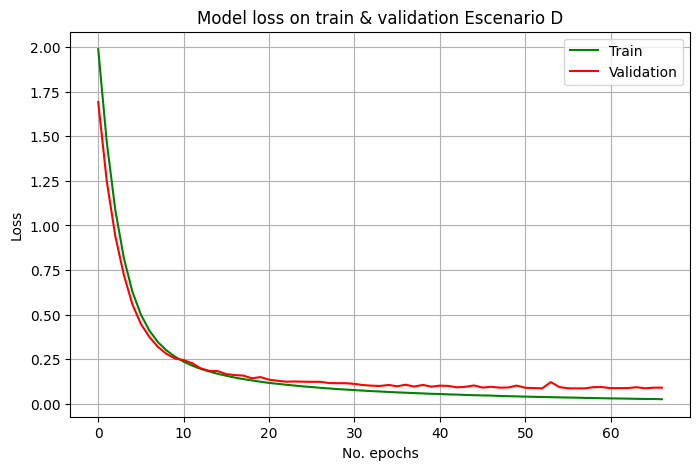

In [21]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation Escenario D')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'g', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

##Esc E

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
import time

# -- Modelo con una capa oculta de 10 neuronas y activación ReLU --
model = nn.Sequential(
    nn.Linear(64, 10),  # Capa de entrada
    nn.ReLU(),          # Función de activación ReLU en la primera capa oculta
    nn.Linear(10, 10),  # Primera capa oculta con 10 neuronas
    nn.ReLU(),          # Función de activación ReLU en la segunda capa oculta
    nn.Linear(10, 10),  # Segunda capa oculta con 10 neuronas
    nn.Linear(10, 10)   # Capa de salida
)

# Se le indica a PyTorch que correremos el modelo en GPU si está disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Definimos la función de pérdida y el optimizador que utilizaremos
criterion = nn.CrossEntropyLoss()                      # Función de pérdida
optimizer = optim.Adam(model.parameters(), lr=1e-3)    # Optimizador

start = time.time()

# Guardar resultados del loss y las épocas que duró el entrenamiento
loss_train = []
loss_val = []
accuracy_val = []  # Lista para guardar el accuracy de validación
epochs = []

# Entrenamiento de la red por un máximo de 1000 épocas
max_epochs = 1000

# Variables para el early stopping
best_val_loss = float('inf')
patience = 10  # Número máximo de épocas sin mejora permitidas
counter = 0

for epoch in range(max_epochs):
    # Guardar loss y accuracy de cada batch
    loss_train_batches = []
    loss_val_batches = []
    accuracy_val_batches = []  # Lista para guardar el accuracy de validación por lotes

    # Entrenamiento --------------------------------------------------------------
    model.train()
    # Debemos recorrer cada batch (lote de los datos)
    for i, data in enumerate(dataloader_train, 0):
        # Procesar el batch actual
        inputs = data["features"].to(device)  # Características
        labels = data["labels"].to(device)    # Clases
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_train_batches.append(loss.item())

    # Guardamos el loss de entrenamiento de la época actual
    loss_train.append(np.mean(loss_train_batches))

    # Validación --------------------------------------------------------------
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_val_batches.append(loss.item())

            # Calcula las predicciones del modelo
            _, predicted = torch.max(outputs, 1)

            # Convierte las etiquetas y predicciones al formato de CPU para calcular el accuracy
            labels_cpu = labels.cpu().numpy()
            predicted_cpu = predicted.cpu().numpy()

            accuracy = accuracy_score(labels_cpu, predicted_cpu)
            accuracy_val_batches.append(accuracy)

    # Guardamos el Loss de validación y el accuracy de validación de la época actual
    loss_val.append(np.mean(loss_val_batches))
    accuracy_val.append(np.mean(accuracy_val_batches))

    # Guardamos la época
    epochs.append(epoch)

    # Imprimir la pérdida de entrenamiento/validación y el accuracy de validación en la época actual
    print(f"Epoch: {epoch}, train loss: {loss_train[epoch]:.4f}, val loss: {loss_val[epoch]:.4f}, val accuracy: {accuracy_val[epoch]:.4f}")

    # Early Stopping: Verificar si la pérdida de validación ha dejado de mejorar
    if loss_val[epoch] < best_val_loss:
        best_val_loss = loss_val[epoch]
        counter = 0  # Reiniciar el contador
    else:
        counter += 1

    if counter >= patience:
        print("Deteniendo el entrenamiento debido a falta de mejora en la validación.")
        break  # Salir del bucle de entrenamiento

end = time.time()
print(f'Finished Training, total time {end - start:.2f} seconds')


Epoch: 0, train loss: 2.3050, val loss: 2.2598, val accuracy: 0.1159
Epoch: 1, train loss: 2.2126, val loss: 2.1410, val accuracy: 0.1695
Epoch: 2, train loss: 2.0682, val loss: 1.9710, val accuracy: 0.2784
Epoch: 3, train loss: 1.8571, val loss: 1.7208, val accuracy: 0.3797
Epoch: 4, train loss: 1.5910, val loss: 1.4567, val accuracy: 0.4894
Epoch: 5, train loss: 1.3173, val loss: 1.2153, val accuracy: 0.6013
Epoch: 6, train loss: 1.0744, val loss: 0.9879, val accuracy: 0.6648
Epoch: 7, train loss: 0.8862, val loss: 0.8385, val accuracy: 0.6859
Epoch: 8, train loss: 0.7487, val loss: 0.7083, val accuracy: 0.7355
Epoch: 9, train loss: 0.6476, val loss: 0.6149, val accuracy: 0.8549
Epoch: 10, train loss: 0.5561, val loss: 0.5466, val accuracy: 0.8790
Epoch: 11, train loss: 0.4693, val loss: 0.4501, val accuracy: 0.8968
Epoch: 12, train loss: 0.3978, val loss: 0.3933, val accuracy: 0.9039
Epoch: 13, train loss: 0.3443, val loss: 0.3611, val accuracy: 0.9103
Epoch: 14, train loss: 0.3070,

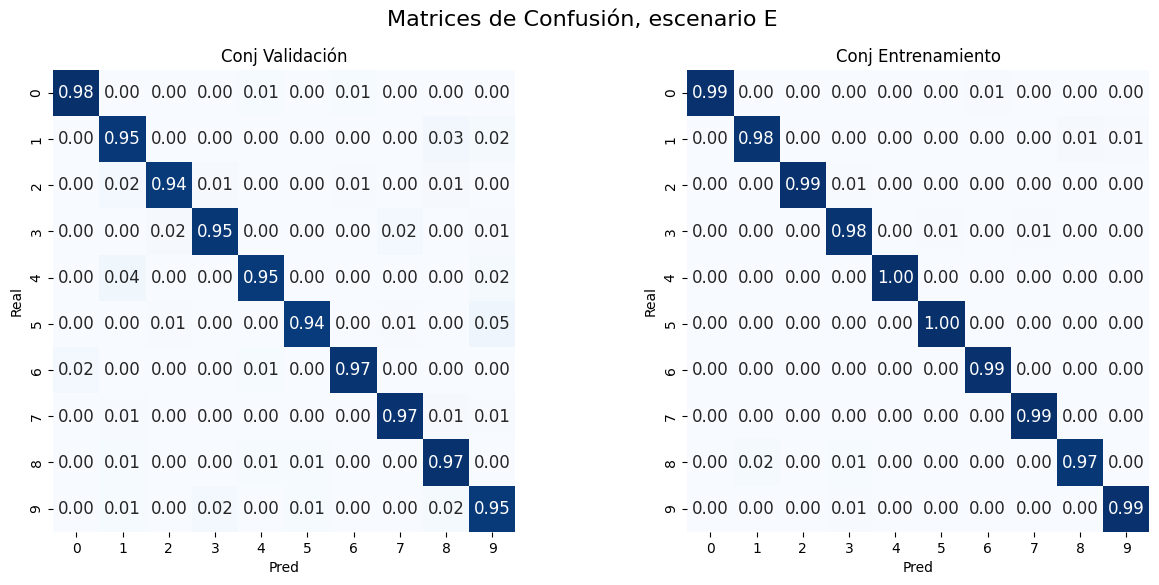

Precisión de entrenamiento: 98.72%
Precisión de validación: 95.79%


In [23]:
#matrices

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener predicciones y etiquetas para el conjunto de validación
val_preds = []
val_labels = []

model.eval()  # Cambiar el modo del modelo a evaluación
with torch.no_grad():
    for batch in dataloader_val:
        features, labels = batch["features"].to(device), batch["labels"].to(device)
        outputs = model(features)  # Realizar predicciones
        _, preds = torch.max(outputs, 1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Obtener predicciones y etiquetas para el conjunto de entrenamiento
train_preds = []
train_labels = []

model.eval()  # Cambiar el modo del modelo a evaluación
with torch.no_grad():
    for batch in dataloader_train:
        features, labels = batch["features"].to(device), batch["labels"].to(device)
        outputs = model(features)  # Realizar predicciones
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

# Calcular las matrices de confusión
val_confusion = confusion_matrix(val_labels, val_preds, normalize='true')
train_confusion = confusion_matrix(train_labels, train_preds, normalize='true')

# Crear una figura y ejes para la matriz de confusión
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Matrices de Confusión, escenario E", fontsize=16)

# Visualizar la matriz de confusión de validación
ax = axes[0]
sns.heatmap(val_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=False, square=True, ax=ax, annot_kws={"size": 12})
ax.set_title("Conj Validación")
ax.set_xlabel('Pred')
ax.set_ylabel('Real')

# Visualizar la matriz de confusión de entrenamiento
ax = axes[1]
sns.heatmap(train_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=False, square=True, ax=ax, annot_kws={"size": 12})
ax.set_title("Conj Entrenamiento")
ax.set_xlabel('Pred')
ax.set_ylabel('Real')

# Mostrar la figura
plt.show()

# Calcular y mostrar las precisiones de entrenamiento y validación
train_accuracy = accuracy_score(train_labels, train_preds)
val_accuracy = accuracy_score(val_labels, val_preds)

print(f'Precisión de entrenamiento: {train_accuracy * 100:.2f}%')
print(f'Precisión de validación: {val_accuracy * 100:.2f}%')

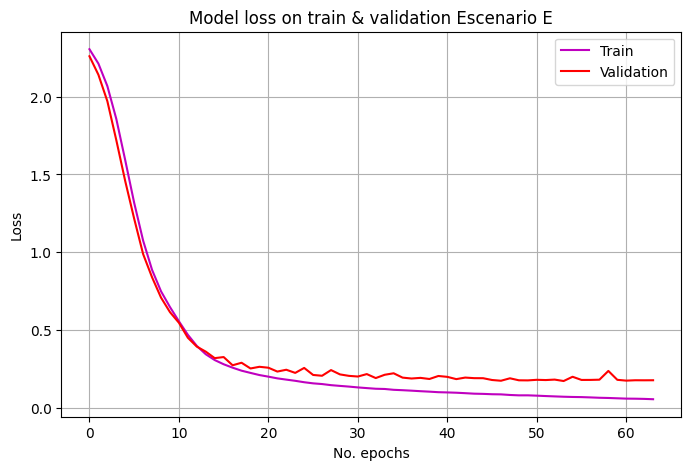

In [24]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation Escenario E')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'm', label = 'Train')
plt.plot(epochs, loss_val, 'r', label = 'Validation')
plt.grid()
plt.legend()

#Esc F

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
import time

# -- Modelo con 2 capas ocultas, cada una con 40 neuronas y activación ReLU --
model = nn.Sequential(
    nn.Linear(64, 40),  # Capa de entrada
    nn.ReLU(),          # Función de activación ReLU en la primera capa oculta
    nn.Linear(40, 40),  # Primera capa oculta con 40 neuronas
    nn.ReLU(),          # Función de activación ReLU en la segunda capa oculta
    nn.Linear(40, 10)   # Segunda capa oculta con 40 neuronas y Capa de salida con 10 neuronas
)

# Se le indica a PyTorch que correremos el modelo en GPU si está disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Definimos la función de pérdida y el optimizador que utilizaremos
criterion = nn.CrossEntropyLoss()                      # Función de pérdida
optimizer = optim.Adam(model.parameters(), lr=1e-3)    # Optimizador

start = time.time()

# Guardar resultados del loss y las épocas que duró el entrenamiento
loss_train = []
loss_val = []
accuracy_val = []  # Lista para guardar el accuracy de validación
epochs = []

# Entrenamiento de la red por un máximo de 1000 épocas
max_epochs = 1000

# Variables para el early stopping
best_val_loss = float('inf')
patience = 10  # Número máximo de épocas sin mejora permitidas
counter = 0

for epoch in range(max_epochs):
    # Guardar loss y accuracy de cada batch
    loss_train_batches = []
    loss_val_batches = []
    accuracy_val_batches = []  # Lista para guardar el accuracy de validación por lotes

    # Entrenamiento --------------------------------------------------------------
    model.train()
    # Debemos recorrer cada batch (lote de los datos)
    for i, data in enumerate(dataloader_train, 0):
        # Procesar el batch actual
        inputs = data["features"].to(device)  # Características
        labels = data['labels'].to(device)    # Clases
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_train_batches.append(loss.item())

    # Guardamos el loss de entrenamiento de la época actual
    loss_train.append(np.mean(loss_train_batches))

    # Validación --------------------------------------------------------------
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader_val, 0):
            inputs = data['features'].to(device)
            labels = data['labels'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_val_batches.append(loss.item())

            # Calcula las predicciones del modelo
            _, predicted = torch.max(outputs, 1)

            # Convierte las etiquetas y predicciones al formato de CPU para calcular el accuracy
            labels_cpu = labels.cpu().numpy()
            predicted_cpu = predicted.cpu().numpy()

            accuracy = accuracy_score(labels_cpu, predicted_cpu)
            accuracy_val_batches.append(accuracy)

    # Guardamos el Loss de validación y el accuracy de validación de la época actual
    loss_val.append(np.mean(loss_val_batches))
    accuracy_val.append(np.mean(accuracy_val_batches))

    # Guardamos la época
    epochs.append(epoch)

    # Imprimir la pérdida de entrenamiento/validación y el accuracy de validación en la época actual
    print(f"Epoch: {epoch}, train loss: {loss_train[epoch]:.4f}, val loss: {loss_val[epoch]:.4f}, val accuracy: {accuracy_val[epoch]:.4f}")

    # Early Stopping: Verificar si la pérdida de validación ha dejado de mejorar
    if loss_val[epoch] < best_val_loss:
        best_val_loss = loss_val[epoch]
        counter = 0  # Reiniciar el contador
    else:
        counter += 1

    if counter >= patience:
        print("Deteniendo el entrenamiento debido a falta de mejora en la validación.")
        break  # Salir del bucle de entrenamiento

end = time.time()
print(f'Finished Training, total time {end - start:.2f} seconds')


Epoch: 0, train loss: 2.1925, val loss: 2.0321, val accuracy: 0.6386
Epoch: 1, train loss: 1.8064, val loss: 1.4741, val accuracy: 0.6890
Epoch: 2, train loss: 1.1961, val loss: 0.8939, val accuracy: 0.8335
Epoch: 3, train loss: 0.6964, val loss: 0.4988, val accuracy: 0.8961
Epoch: 4, train loss: 0.4110, val loss: 0.3562, val accuracy: 0.9136
Epoch: 5, train loss: 0.2870, val loss: 0.2496, val accuracy: 0.9372
Epoch: 6, train loss: 0.2229, val loss: 0.1992, val accuracy: 0.9545
Epoch: 7, train loss: 0.1833, val loss: 0.1992, val accuracy: 0.9443
Epoch: 8, train loss: 0.1550, val loss: 0.1581, val accuracy: 0.9558
Epoch: 9, train loss: 0.1341, val loss: 0.1380, val accuracy: 0.9594
Epoch: 10, train loss: 0.1164, val loss: 0.1477, val accuracy: 0.9616
Epoch: 11, train loss: 0.1037, val loss: 0.1202, val accuracy: 0.9659
Epoch: 12, train loss: 0.0919, val loss: 0.1095, val accuracy: 0.9688
Epoch: 13, train loss: 0.0823, val loss: 0.1065, val accuracy: 0.9702
Epoch: 14, train loss: 0.0761,

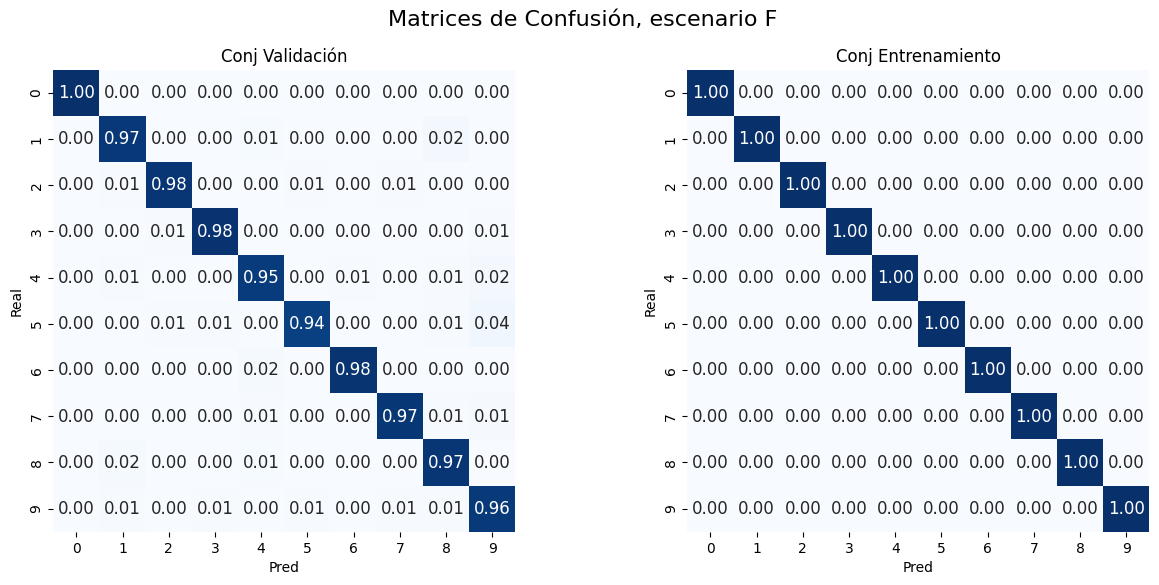

Precisión de entrenamiento: 100.00%
Precisión de validación: 97.16%


In [26]:
#matrices

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener predicciones y etiquetas para el conjunto de validación
val_preds = []
val_labels = []

model.eval()  # Cambiar el modo del modelo a evaluación
with torch.no_grad():
    for batch in dataloader_val:
        features, labels = batch["features"].to(device), batch["labels"].to(device)
        outputs = model(features)  # Realizar predicciones
        _, preds = torch.max(outputs, 1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Obtener predicciones y etiquetas para el conjunto de entrenamiento
train_preds = []
train_labels = []

model.eval()  # Cambiar el modo del modelo a evaluación
with torch.no_grad():
    for batch in dataloader_train:
        features, labels = batch["features"].to(device), batch["labels"].to(device)
        outputs = model(features)  # Realizar predicciones
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

# Calcular las matrices de confusión
val_confusion = confusion_matrix(val_labels, val_preds, normalize='true')
train_confusion = confusion_matrix(train_labels, train_preds, normalize='true')

# Crear una figura y ejes para la matriz de confusión
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Matrices de Confusión, escenario F", fontsize=16)

# Visualizar la matriz de confusión de validación
ax = axes[0]
sns.heatmap(val_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=False, square=True, ax=ax, annot_kws={"size": 12})
ax.set_title("Conj Validación")
ax.set_xlabel('Pred')
ax.set_ylabel('Real')

# Visualizar la matriz de confusión de entrenamiento
ax = axes[1]
sns.heatmap(train_confusion, annot=True, fmt='.2f', cmap='Blues', cbar=False, square=True, ax=ax, annot_kws={"size": 12})
ax.set_title("Conj Entrenamiento")
ax.set_xlabel('Pred')
ax.set_ylabel('Real')

# Mostrar la figura
plt.show()

# Calcular y mostrar las precisiones de entrenamiento y validación
train_accuracy = accuracy_score(train_labels, train_preds)
val_accuracy = accuracy_score(val_labels, val_preds)

print(f'Precisión de entrenamiento: {train_accuracy * 100:.2f}%')
print(f'Precisión de validación: {val_accuracy * 100:.2f}%')

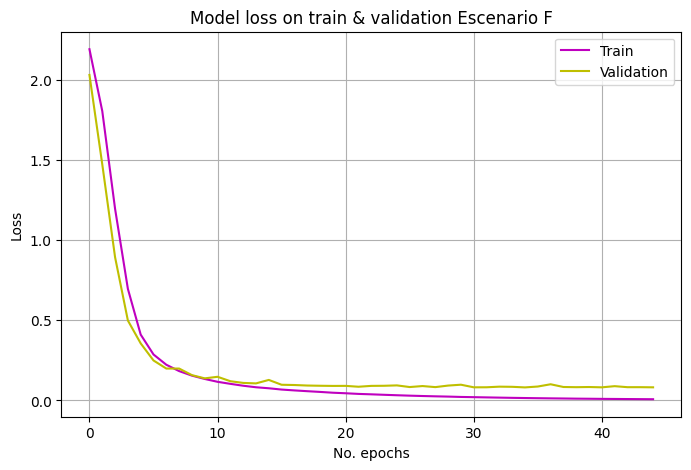

In [27]:
import matplotlib.pyplot as plt

# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('Model loss on train & validation Escenario F')
plt.xlabel('No. epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss_train, 'm', label = 'Train')
plt.plot(epochs, loss_val, 'y', label = 'Validation')
plt.grid()
plt.legend()

#Mejor escenario con conjunto de prueba

Epoch: 0, train loss: 2.0955, val loss: 1.8721, val accuracy: 0.6243
Epoch: 1, train loss: 1.6558, val loss: 1.4307, val accuracy: 0.7553
Epoch: 2, train loss: 1.2195, val loss: 0.9988, val accuracy: 0.8244
Epoch: 3, train loss: 0.8563, val loss: 0.7228, val accuracy: 0.8675
Epoch: 4, train loss: 0.6074, val loss: 0.5046, val accuracy: 0.9141
Epoch: 5, train loss: 0.4498, val loss: 0.3874, val accuracy: 0.9347
Epoch: 6, train loss: 0.3534, val loss: 0.3168, val accuracy: 0.9366
Epoch: 7, train loss: 0.2919, val loss: 0.2669, val accuracy: 0.9496
Epoch: 8, train loss: 0.2502, val loss: 0.2370, val accuracy: 0.9481
Epoch: 9, train loss: 0.2200, val loss: 0.2038, val accuracy: 0.9553
Epoch: 10, train loss: 0.1958, val loss: 0.1911, val accuracy: 0.9508
Epoch: 11, train loss: 0.1775, val loss: 0.1816, val accuracy: 0.9580
Epoch: 12, train loss: 0.1625, val loss: 0.1636, val accuracy: 0.9638
Epoch: 13, train loss: 0.1502, val loss: 0.1535, val accuracy: 0.9638
Epoch: 14, train loss: 0.1387,

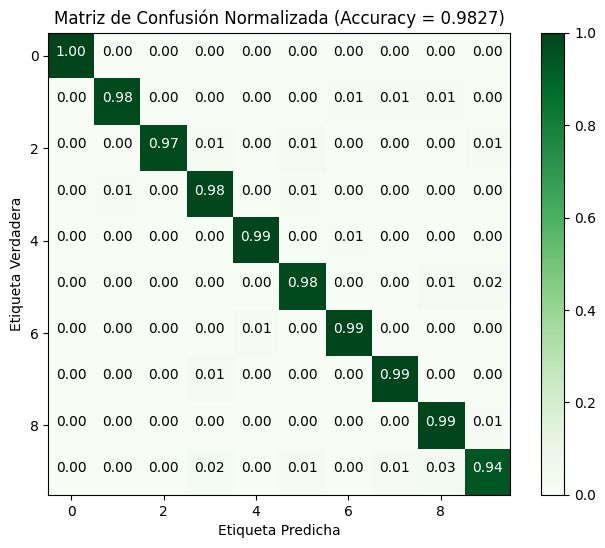

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
import time

# -- Modelo con una capa oculta de 10 neuronas y activación ReLU --
model = nn.Sequential(
    nn.Linear(64, 40),  # Capa de entrada
    nn.ReLU(),          # Función de activación ReLU
    nn.Linear(40, 10)   # Capa de salida
)

# Se le indica a PyTorch que correremos el modelo en GPU si está disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Definimos la función de pérdida y el optimizador que utilizaremos
criterion = nn.CrossEntropyLoss()                      # Función de pérdida
optimizer = optim.Adam(model.parameters(), lr=1e-3)    # Optimizador

start = time.time()

# Guardar resultados del loss y las épocas que duró el entrenamiento
loss_train = []
loss_val = []
accuracy_val = []  # Lista para guardar el accuracy de validación
epochs = []

# Entrenamiento de la red por un máximo de 1000 épocas
max_epochs = 1000

# Variables para el early stopping
best_val_loss = float('inf')
patience = 10  # Número máximo de épocas sin mejora permitidas
counter = 0

for epoch in range(max_epochs):
    # Guardar loss y accuracy de cada batch
    loss_train_batches = []
    loss_val_batches = []
    accuracy_val_batches = []  # Lista para guardar el accuracy de validación por lotes

    # Entrenamiento --------------------------------------------------------------
    model.train()
    # Debemos recorrer cada batch (lote de los datos)
    for i, data in enumerate(dataloader_train, 0):
        # Procesar el batch actual
        inputs = data["features"].to(device)  # Características
        labels = data["labels"].to(device)    # Clases
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_train_batches.append(loss.item())

    # Guardamos el loss de entrenamiento de la época actual
    loss_train.append(np.mean(loss_train_batches))

    # Validación --------------------------------------------------------------
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader_val, 0):
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_val_batches.append(loss.item())

            # Calcula las predicciones del modelo
            _, predicted = torch.max(outputs, 1)

            # Convierte las etiquetas y predicciones al formato de CPU para calcular el accuracy
            labels_cpu = labels.cpu().numpy()
            predicted_cpu = predicted.cpu().numpy()

            accuracy = accuracy_score(labels_cpu, predicted_cpu)
            accuracy_val_batches.append(accuracy)

    # Guardamos el Loss de validación y el accuracy de validación de la época actual
    loss_val.append(np.mean(loss_val_batches))
    accuracy_val.append(np.mean(accuracy_val_batches))

    # Guardamos la época
    epochs.append(epoch)

    # Imprimir la pérdida de entrenamiento/validación y el accuracy de validación en la época actual
    print(f"Epoch: {epoch}, train loss: {loss_train[epoch]:.4f}, val loss: {loss_val[epoch]:.4f}, val accuracy: {accuracy_val[epoch]:.4f}")

    # Early Stopping: Verificar si la pérdida de validación ha dejado de mejorar
    if loss_val[epoch] < best_val_loss:
        best_val_loss = loss_val[epoch]
        counter = 0  # Reiniciar el contador
    else:
        counter += 1

    if counter >= patience:
        print("Deteniendo el entrenamiento debido a falta de mejora en la validación.")
        break  # Salir del bucle de entrenamiento

end = time.time()
print(f'Finished Training, total time {end - start:.2f} seconds')



import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# ... (Tu código previo para definir el modelo, dataloaders, entrenamiento, etc.)

# Evaluación en el conjunto de prueba
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data in dataloader_test:  # Usamos dataloader_test en lugar de dataloader_val
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Convierte las etiquetas y predicciones al formato de CPU
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calcular la matriz de confusión
confusion = confusion_matrix(y_true, y_pred)

# Calcular el accuracy
accuracy = accuracy_score(y_true, y_pred)

# Normalizar la matriz de confusión dividiendo cada fila por su suma
confusion_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

# Visualizar la matriz de confusión con colores según el valor del accuracy
plt.figure(figsize=(8, 6))
plt.imshow(confusion_normalized, interpolation='nearest', cmap=plt.cm.Greens)

# Agregar anotaciones con valores en las celdas y colores
for i in range(confusion_normalized.shape[0]):
    for j in range(confusion_normalized.shape[1]):
        color = 'white' if confusion_normalized[i, j] > 0.5 else 'black'
        plt.text(j, i, "{:.2f}".format(confusion_normalized[i, j]), horizontalalignment="center", color=color)

plt.title(f'Matriz de Confusión Normalizada (Accuracy = {accuracy:.4f})')
plt.colorbar()
# No es necesario mostrar los nombres de las clases en este caso
# plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
# plt.yticks(np.arange(len(class_names)), class_names)
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()
